# Shape Morphing Experiments

This file contains all the code for experiments we performed related to shape morphing.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from skimage import measure
from scipy.interpolate import interp1d
from skimage.draw import polygon
from PIL import Image, ImageOps
from shapely.geometry import Polygon
import datetime

# Functions

### shape creation

In [6]:
def create_circle(center=(100, 100), radius=40, size=(200, 200)):
    y, x = np.ogrid[:size[0], :size[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    return mask.astype(np.uint8)

def create_square(top_left=(60, 60), length=80, size=(200, 200)):
    mask = np.zeros(size, dtype=np.uint8)
    mask[top_left[1]:top_left[1]+length, top_left[0]:top_left[0]+length] = 1
    return mask

def create_diamond(center=(100, 100), size=80, img_size=(200, 200)):
    y, x = np.ogrid[:img_size[0], :img_size[1]]
    mask = np.abs(x - center[0]) + np.abs(y - center[1]) <= size // 2
    return mask.astype(np.uint8)

def create_triangle(vertices=[(100, 60), (60, 140), (140, 140)], img_size=(200, 200)):
    rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img_size)
    mask = np.zeros(img_size, dtype=np.uint8)
    mask[rr, cc] = 1
    return mask

def create_polygon(vertices, img_size=(200, 200)):
    from skimage.draw import polygon
    rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img_size)
    mask = np.zeros(img_size, dtype=np.uint8)
    mask[rr, cc] = 1
    return mask

def create_star(n_points=5, r_outer=40, r_inner=20, center=(100, 100), img_size=(200, 200)):
    angles = np.linspace(0, 2*np.pi, n_points*2, endpoint=False)
    radii = np.array([r_outer if i % 2 == 0 else r_inner for i in range(len(angles))])
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)
    return create_polygon(list(zip(x, y)), img_size)

### contour extraction

In [7]:
def is_clockwise(x, y):
    return np.sum((x[1:] - x[:-1]) * (y[1:] + y[:-1])) > 0

def set_contour_clockwise(x, y):
    if is_clockwise(x, y):
        return x[::-1], y[::-1]
    return x, y

# function to resample contours points to evenly spaced points
# with counter-clockwise directionality
def resample_contour(x, y, num_points=256):
    dx = np.diff(x)
    dy = np.diff(y)
    distances = np.sqrt(dx**2 + dy**2)
    cumulative = np.concatenate(([0], np.cumsum(distances)))
    total_length = cumulative[-1]

    fx = interp1d(cumulative, x)
    fy = interp1d(cumulative, y)

    new_distances = np.linspace(0, total_length, num_points)
    x_resampled = fx(new_distances)
    y_resampled = fy(new_distances)

    # ensure contour is counter-clockwise
    x_resampled, y_resampled = set_contour_clockwise(x_resampled, y_resampled)
    
    return x_resampled, y_resampled

# function to recenter all contour points
def recenter_contour(x, y, shift=(0, 0)):
    x_centered = x - shift[0]
    y_centered = y - shift[1]
    return x_centered, y_centered
  
# extract a contour from a binary mask with a specified number of points
def extract_contour(binary_mask, num_points=256):
    contours = measure.find_contours(binary_mask, 0.5)
    largest = max(contours, key=len)
    return resample_contour(largest[:, 1], largest[:, 0], num_points)

### fourier descriptors and reconstruction

In [8]:
def compute_fd(x, y):
    z = x + 1j * y
    Z = np.fft.fft(z)
    return Z

# essentilaly apply a low-pass filter to keep only low-frequency components
# symetrically
def low_pass(Z, num_points=256):
    Z_ = np.zeros_like(Z, dtype=complex)
    Z_[0] = Z[0]
    Z_[1:num_points//2] = Z[1:num_points//2]
    Z_[-num_points//2+1:] = Z[-num_points//2+1:]
    return Z_
  
def reconstruct_shape(Z):
    z = np.fft.ifft(Z)
    return z.real, z.imag

### interpolation methods

In [ ]:
# Interpolation real-imaginary
def interpolate_fd_real_imag(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)
    interpolated = []
    for k in range(fd_array.shape[1]):
        real_interp = np.interp(target_t, t_vals, fd_array[:, k].real)
        imag_interp = np.interp(target_t, t_vals, fd_array[:, k].imag)
        interpolated.append(real_interp + 1j * imag_interp)
    return np.array(interpolated)
  
# Interpolation magnitude-phase 
def interpolate_fd_magnitude_angle(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)
    interpolated = []

    for k in range(fd_array.shape[1]):
        mag = np.abs(fd_array[:, k])
        angle = np.angle(fd_array[:, k])

        def interp_angle(theta1, theta2, t):
            diff = ((theta2 - theta1 + np.pi) % (2 * np.pi)) - np.pi
            return theta1 + t * diff

        mag_interp = np.interp(target_t, t_vals, mag)
        angle_interp = interp_angle(angle[0], angle[1], (target_t - t_vals[0]) / (t_vals[1] - t_vals[0]))

        interpolated.append(mag_interp * np.exp(1j * angle_interp))

    return np.array(interpolated)

# Hybrid interpolation: real-imag for low freq, mag-phase for high freq
def interpolate_fd_hybrid(fd_seq, t_vals, target_t, split_k=10, low=True):
    fd_array = np.array(fd_seq)  # shape: (T, N)
    N = fd_array.shape[1]
    interpolated = []

    for k in range(N):
        if (low and k < split_k) or (not low and k >= split_k):
            # Real-imag interpolation
            real_interp = np.interp(target_t, t_vals, fd_array[:, k].real)
            imag_interp = np.interp(target_t, t_vals, fd_array[:, k].imag)
            interpolated.append(real_interp + 1j * imag_interp)
        else:
            # Magnitude-phase interpolation
            mag = np.abs(fd_array[:, k])
            angle = np.angle(fd_array[:, k])
            def interp_angle(theta1, theta2, t):
                diff = ((theta2 - theta1 + np.pi) % (2 * np.pi)) - np.pi
                return theta1 + t * diff
            mag_interp = np.interp(target_t, t_vals, mag)
            angle_interp = interp_angle(angle[0], angle[1], (target_t - t_vals[0]) / (t_vals[1] - t_vals[0]))
            interpolated.append(mag_interp * np.exp(1j * angle_interp))

    return np.array(interpolated)

# Linear interpolation directly between contours
def interpolate_contours_linear(contour1, contour2, t):
    x1, y1 = contour1
    x2, y2 = contour2
    x_interp = (1 - t) * x1 + t * x2
    y_interp = (1 - t) * y1 + t * y2
    return x_interp, y_interp

### validation

In [ ]:
# compute the area of a contour
def contour_area(x, y):
  return 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
  
# compute the overlap degree between two contours
def overlap_degree(est_contour, actual_contour):
  est_contour = np.array(est_contour).T
  actual_contour = np.array(actual_contour).T
  
  actual = Polygon(actual_contour)
  est = Polygon(est_contour)
  if not est.is_valid:
    est = est.buffer(0)
    
  if not actual.is_valid:
    actual = actual.buffer(0) 
    
  intersection = actual.intersection(est)
  
  return intersection.area / actual.area


# 1. Fourier Shape Reconstruction

In [66]:
num_params = 256

# prepare contours and compute fds
slc_contour = np.load('SLC/SLC_mask_2015.npy')
x1, y1 = extract_contour(slc_contour)
x_lake, y_lake = resample_contour(x1, y1, num_points=256)

x_square, y_square = extract_contour(create_square(), num_points=num_params)
x_triangle, y_triangle = extract_contour(create_triangle(), num_points=num_params)
x_star, y_star = extract_contour(create_star(), num_points=num_params)

fd_square = compute_fd(x_square, y_square)
fd_triangle = compute_fd(x_triangle, y_triangle)
fd_star = compute_fd(x_star, y_star)
fd_lake = compute_fd(x_lake, y_lake)

In [ ]:
shapes = [
    ("Square", fd_square, (x_square, y_square)),
    ("Triangle", fd_triangle, (x_triangle, y_triangle)),
    ("Star", fd_star, (x_star, y_star)),
    ("Lake", fd_lake, (x_lake, y_lake)),
]

n_values = [4, 10, 20, 40, 256]

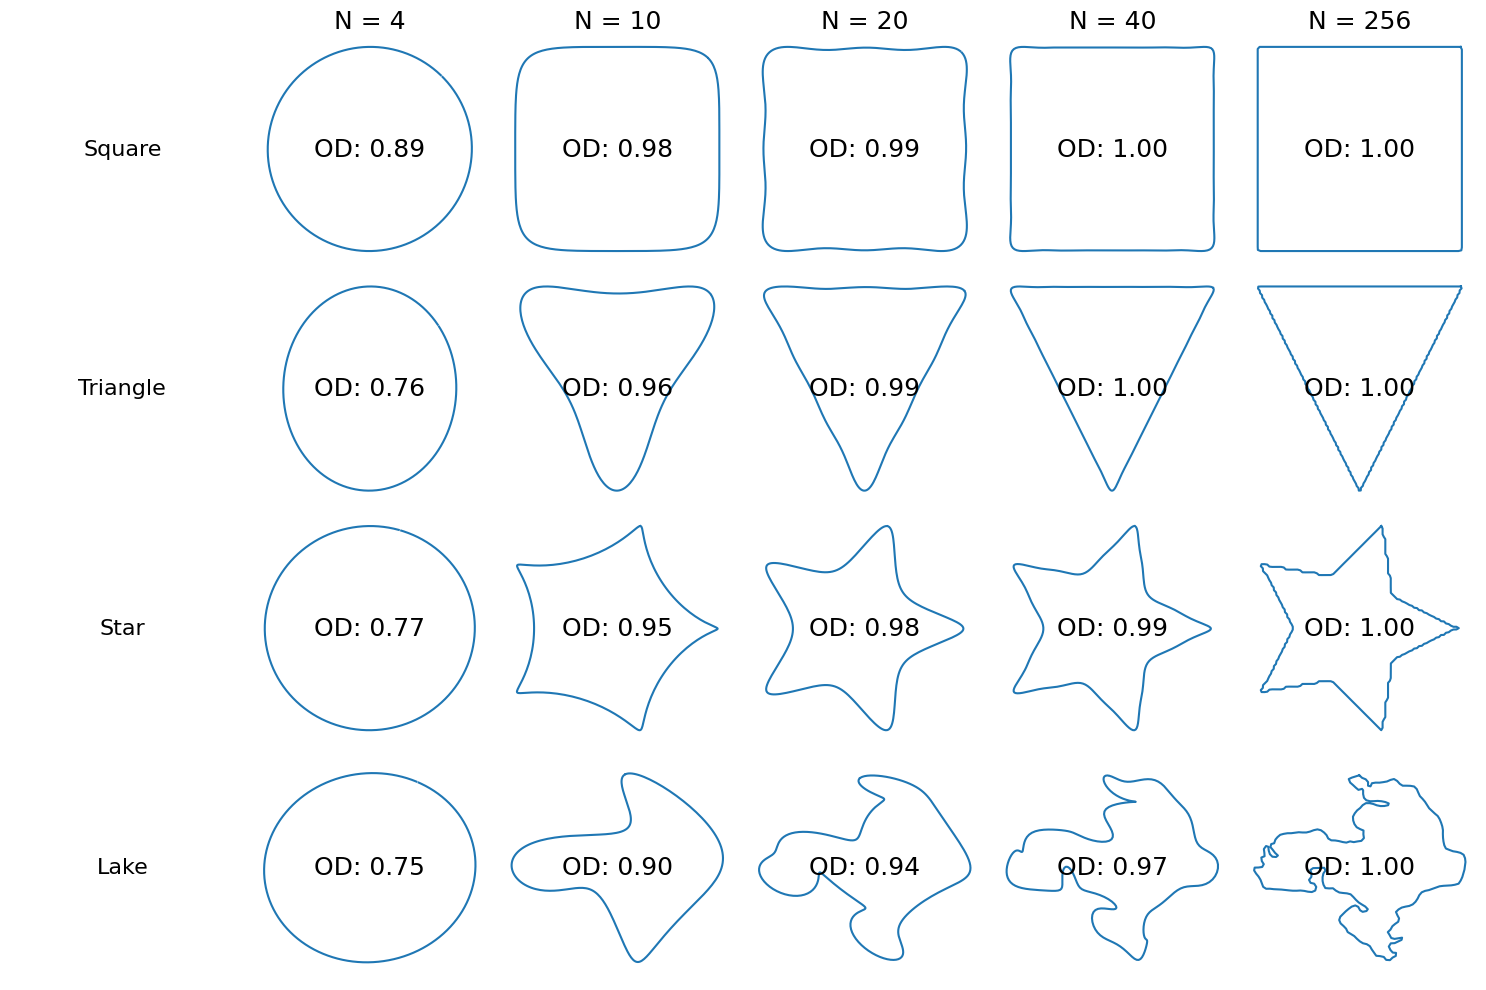

In [74]:
od_results = {}

fig, axs = plt.subplots(len(shapes), len(n_values)+1, figsize=(2.5 * (len(n_values)+1), 2.5 * len(shapes)))

for i, (label, fd, orig) in enumerate(shapes):
    od_results[label] = []
    # Original contour for this shape
    x_orig, y_orig = orig[0], orig[1]

    for j, n in enumerate([0] + n_values):
        if j == 0:
            axs[i, j].text(0.5, 0.5, label, fontsize=16,
                           transform=axs[i, j].transAxes,
                           verticalalignment='center',
                           horizontalalignment='center')
            axs[i, j].set_aspect('equal')
            axs[i, j].axis('off')
            continue
        fd_ = low_pass(fd, num_points=n)
        x_rec, y_rec = reconstruct_shape(fd_)
        axs[i, j].plot(x_rec, y_rec)
        axs[i, j].set_aspect('equal')
        axs[i, j].axis('off')

        x_rec = x_rec - np.mean(x_rec) + np.mean(x_orig)
        y_rec = y_rec - np.mean(y_rec) + np.mean(y_orig)
        od = overlap_degree((x_orig, y_orig), (x_rec, y_rec))
        od_results[label].append(od)

        # Plot OD value in the center
        axs[i, j].text(0.5, 0.5, f'OD: {od:.2f}', fontsize=18,
                           transform=axs[i, j].transAxes,
                           verticalalignment='center',
                           horizontalalignment='center')

        if i == 0:
            axs[i, j].set_title(f'N = {int(n)}', fontsize=18)


plt.tight_layout()
plt.show()


# 2. Basic Experimentation

In [11]:
# given two binary masks, extract contours, interpolate between them, and visualize the results
def visualize_methods(shape1, shape2, num_params=256, num_steps=10):
  t_vals = np.array(np.linspace(0, 1, num_steps))
  
  x1, y1 = extract_contour(shape1)
  x2, y2 = extract_contour(shape2)
  P1 = compute_fd(x1, y1)
  P2 = compute_fd(x2, y2)
  resampled_contour1 = resample_contour(x1, y1, num_points=num_params)
  resampled_contour2 = resample_contour(x2, y2, num_points=num_params)
  sampled_P1 = low_pass(P1, num_params)
  sampled_P2 = low_pass(P2, num_params)
  
  interp_real_imag = [reconstruct_shape(interpolate_fd_real_imag([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_hybrid = [reconstruct_shape(interpolate_fd_hybrid([sampled_P1, sampled_P2], [0, 1], t, split_k=num_params//3)) for t in t_vals]
  interp_mag_angle = [reconstruct_shape(interpolate_fd_magnitude_angle([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_linear = [interpolate_contours_linear(resampled_contour1, resampled_contour2, t) for t in t_vals]
  
  fig, axs = plt.subplots(4, num_steps, figsize=(15, 10))
  
  for i, idx in enumerate(t_vals):
    x1, y1 = interp_real_imag[i]
    x2, y2 = interp_hybrid[i]
    x3, y3 = interp_mag_angle[i]
    x4, y4 = interp_linear[i]
    
    axs[0, i].plot(x1 - np.mean(x1), y1 - np.mean(y1))
    axs[0, i].set_title(f"Real-Imag g={t_vals[i]:.2f}")
    axs[0, i].invert_yaxis()
    axs[0, i].axis('equal')
    axs[0, i].axis('off')
    
    axs[1, i].plot(x2 - np.mean(x2), y2 - np.mean(y2))
    axs[1, i].set_title(f"Hybrid g={t_vals[i]:.2f}")
    axs[1, i].invert_yaxis()
    axs[1, i].axis('equal')
    axs[1, i].axis('off')
    
    axs[2, i].plot(x3 - np.mean(x3), y3 - np.mean(y3))
    axs[2, i].set_title(f"Mag-Phase g={t_vals[i]:.2f}")
    axs[2, i].invert_yaxis()
    axs[2, i].axis('equal')
    axs[2, i].axis('off')
    
    axs[3, i].plot(x4 - np.mean(x4), y4 - np.mean(y4))
    axs[3, i].set_title(f"Linear g={t_vals[i]:.2f}")
    axs[3, i].invert_yaxis()
    axs[3, i].axis('equal')
    axs[3, i].axis('off')
  
  plt.tight_layout()
  plt.show()

### 2.1 Synthentic Shapes: Circle to Custom Polygon

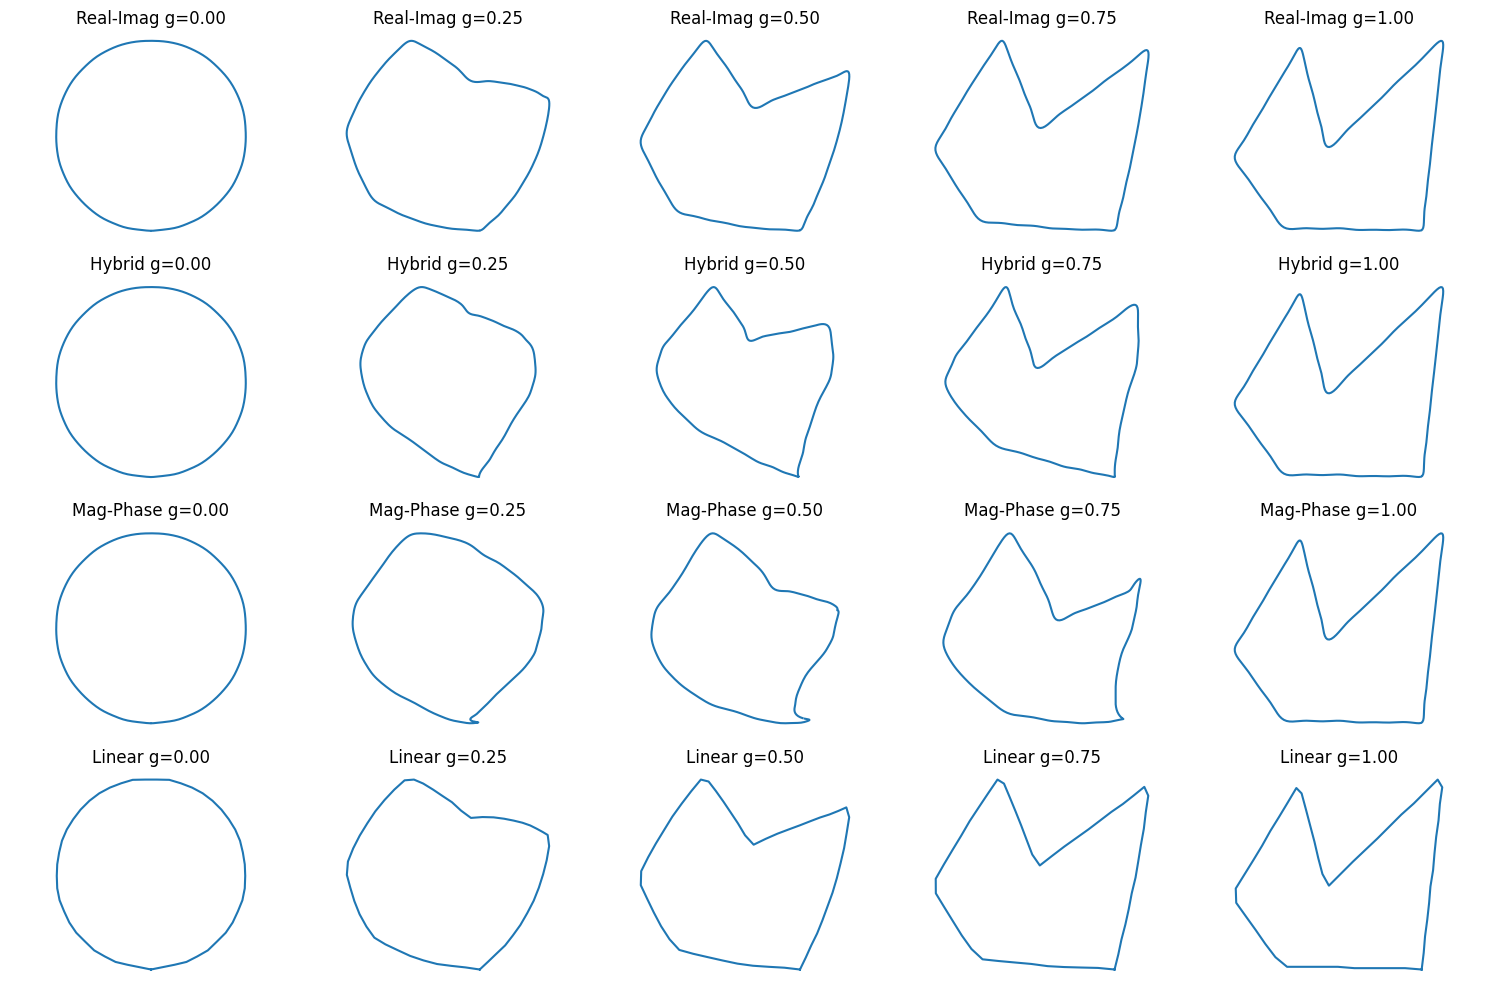

In [12]:
polygon1 = create_circle()
polygon2 = create_polygon(((75, 102), (55, 24), (5, 108), (42, 160), (146, 162), (162, 18)), img_size=(200, 200))

visualize_methods(polygon1, polygon2, num_params=50, num_steps=5)

### 2.2 Illustrative Example: Elephant to Shark

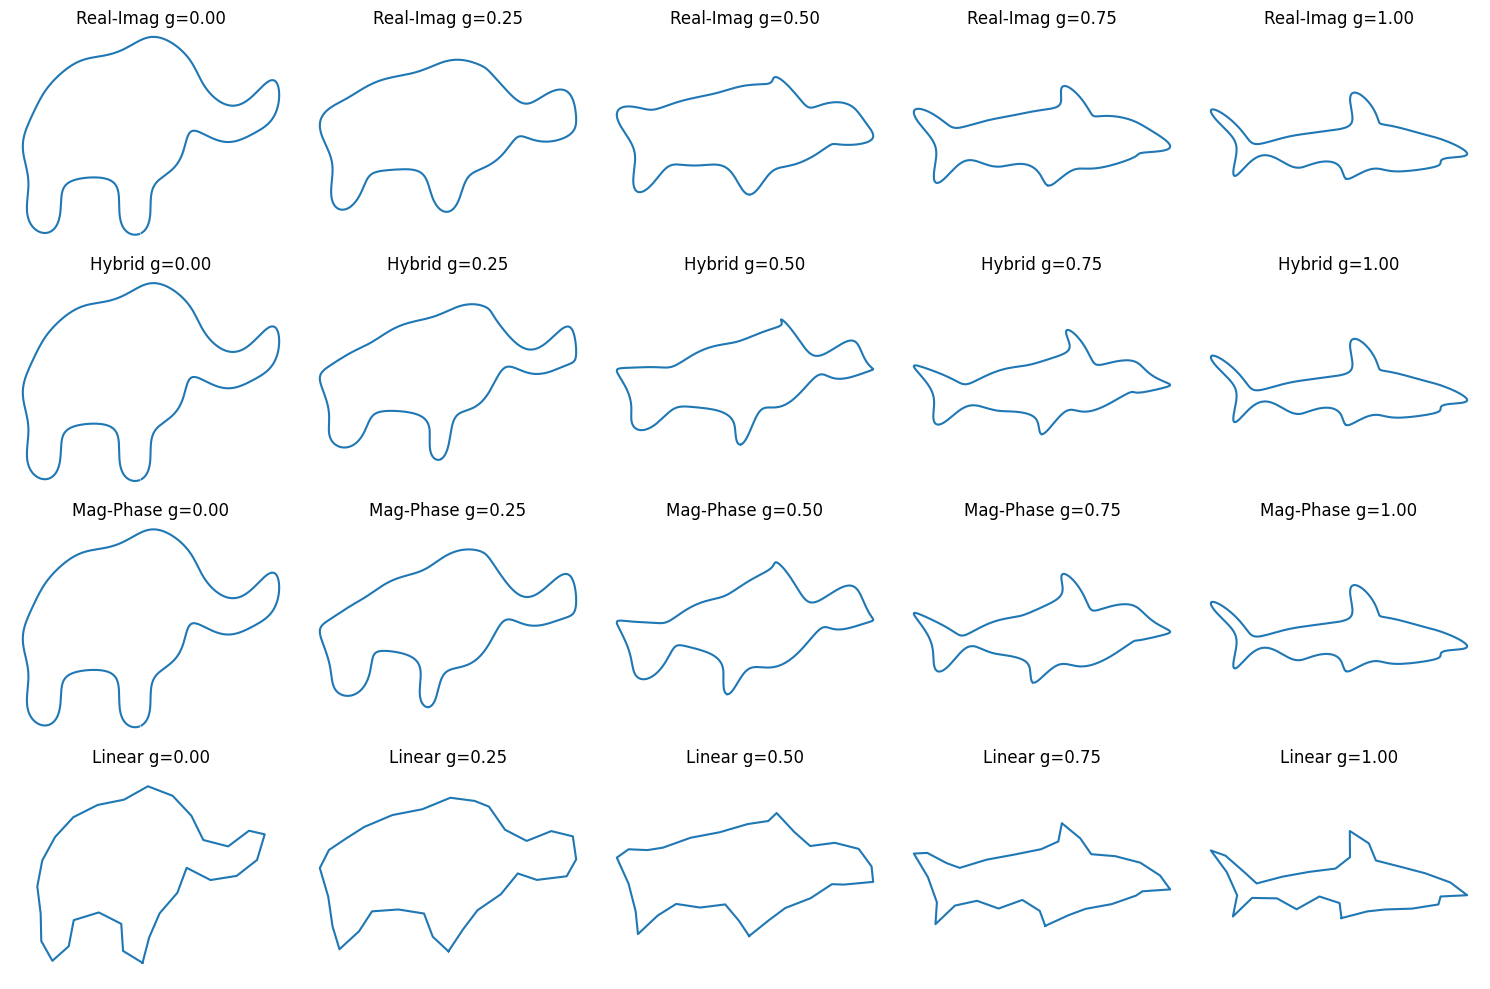

In [13]:
elephant = np.array(Image.open('images/elephant.png').convert('L'))
bin_elephant = (elephant > 200).astype(np.uint8) * 255
shark = np.array(ImageOps.mirror(Image.open('images/shark.png')).convert('L'))
bin_shark = (shark > 200).astype(np.uint8) * 255
visualize_methods(bin_elephant, bin_shark, num_params=30, num_steps=5)

# 3. Real Geographic Contours

In [59]:
# given two binary masks, extract contours, interpolate between them, and visualize the results
def validate_methods(struct, year1, year2, num_params=256, visualize=None, validation="both"):
  num_steps = year2 - year1 + 1
  years = np.arange(year1, year2 + 1)
  t_vals = np.array(np.linspace(0, 1, num_steps))
  
  assert len(years) == num_steps, "Number of years does not match number of steps."
  
  shape1 = np.load(f"{struct}/{struct}_mask_{year1}.npy")
  shape2 = np.load(f"{struct}/{struct}_mask_{year2}.npy")
  x1, y1 = extract_contour(shape1)
  x2, y2 = extract_contour(shape2)
  shift = ((np.min(x1) + np.max(x1)) / 2, (np.min(y1) + np.max(y1)) / 2)
  x1, y1 = recenter_contour(x1, y1, shift=shift)
  x2, y2 = recenter_contour(x2, y2, shift=shift)
  P1 = compute_fd(x1, y1)
  P2 = compute_fd(x2, y2)
  resampled_contour1 = resample_contour(x1, y1, num_points=num_params)
  resampled_contour2 = resample_contour(x2, y2, num_points=num_params)
  sampled_P1 = low_pass(P1, num_params)
  sampled_P2 = low_pass(P2, num_params)
  
  interp_real_imag = [reconstruct_shape(interpolate_fd_real_imag([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_hybrid = [reconstruct_shape(interpolate_fd_hybrid([sampled_P1, sampled_P2], [0, 1], t, split_k=num_params//2)) for t in t_vals]
  interp_mag_angle = [reconstruct_shape(interpolate_fd_magnitude_angle([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_linear = [interpolate_contours_linear(resampled_contour1, resampled_contour2, t) for t in t_vals]
  actual = [extract_contour(np.load(f"{struct}/{struct}_mask_{year}.npy")) for year in years]
  actual = [recenter_contour(x, y, shift=shift) for x, y in actual]
  
  if visualize is not None:
    selected = np.arange(0, num_steps, num_steps // visualize)
    fig, axs = plt.subplots(5, len(selected), figsize=(15, 15))
    
    for pi, i in enumerate(selected):
      x1, y1 = interp_real_imag[i]
      x2, y2 = interp_hybrid[i]
      x3, y3 = interp_mag_angle[i]
      x4, y4 = interp_linear[i]
      x5, y5 = actual[i]
      
      axs[0, pi].plot(x1 - np.mean(x1), y1 - np.mean(y1))
      axs[0, pi].set_title(f"Real-Imag t={years[i]}")
      axs[0, pi].invert_yaxis()
      axs[0, pi].axis('equal')
      axs[0, pi].axis('off')
      
      axs[1, pi].plot(x2 - np.mean(x2), y2 - np.mean(y2))
      axs[1, pi].set_title(f"Hybrid t={years[i]}")
      axs[1, pi].invert_yaxis()
      axs[1, pi].axis('equal')
      axs[1, pi].axis('off')
      
      axs[2, pi].plot(x3 - np.mean(x3), y3 - np.mean(y3))
      axs[2, pi].set_title(f"Mag-Phase t={years[i]}")
      axs[2, pi].invert_yaxis()
      axs[2, pi].axis('equal')
      axs[2, pi].axis('off')

      axs[3, pi].plot(x4 - np.mean(x4), y4 - np.mean(y4))
      axs[3, pi].set_title(f"Linear Interpolation t={years[i]}")
      axs[3, pi].invert_yaxis()
      axs[3, pi].axis('equal')
      axs[3, pi].axis('off')

      
      axs[4, pi].plot(x5 - np.mean(x5), y5 - np.mean(y5))
      axs[4, pi].set_title(f"Actual t={years[i]}")
      axs[4, pi].invert_yaxis()
      axs[4, pi].axis('equal')
      axs[4, pi].axis('off')
  
    plt.tight_layout()
    # plt.savefig(f"{struct}_interpolation_{year1}_{year2}.png")
    plt.show()

  # validation: area comparison 
  if validation == "area" or validation == "both":
    areas = np.array([contour_area(x, y) for x, y in actual])
    areas_interp_mag_angle = np.array([contour_area(x, y) for x, y in interp_mag_angle])
    areas_interp_real_imag = np.array([contour_area(x, y) for x, y in interp_real_imag])
    areas_interp_hybrid = np.array([contour_area(x, y) for x, y in interp_hybrid])
    areas_interp_linear = np.array([contour_area(x, y) for x, y in interp_linear])
    
    plt.figure(figsize=(10, 5))
    plt.plot(years, areas, label='Actual Area', marker='o')
    plt.plot(years, areas_interp_real_imag, label='Interpolated Real-Imag Area', marker='x')
    plt.plot(years, areas_interp_hybrid, label='Interpolated Hybrid Area', marker='x')
    plt.plot(years, areas_interp_mag_angle, label='Interpolated Mag-Phase Area', marker='x')
    plt.plot(years, areas_interp_linear, label='Interpolated Linear Area', marker='x')
    
    # plot linear from start to end
    plt.plot(years, np.linspace(areas[0], areas[-1], num_steps), label='Linear Trend', linestyle='--')
    
    plt.title(f"Area Comparison for {struct}: {year1} to {year2}")
    plt.xlabel("Year")
    plt.ylabel("Area")
    plt.legend()
    # plt.savefig(f"{struct}_area_comparison_{year1}_{year2}.png")
    plt.show()

  # validation: overlap degree  
  if validation == "overlap" or validation == "both":
    min_x = np.min([np.min(x) for x, y in actual])
    max_x = np.max([np.max(x) for x, y in actual])
    min_y = np.min([np.min(y) for x, y in actual])
    max_y = np.max([np.max(y) for x, y in actual])
    
    if visualize is not None:
      for i in range(len(interp_mag_angle)):
        if i == 0 or i == len(interp_mag_angle) - 1 or i in selected:
          real_imag = interp_real_imag[i]
          hybrid = interp_hybrid[i]
          mag_angle = interp_mag_angle[i]
          linear = interp_linear[i]
          act = actual[i]
                
          plt.plot(act[0], act[1], label='Actual Contour')
          plt.plot(real_imag[0], real_imag[1], label=f'Real-Imag OD={overlap_degree(real_imag, act): .2f}', alpha=0.5)
          plt.plot(hybrid[0], hybrid[1], label=f'Hybrid OD={overlap_degree(hybrid, act): .2f}', alpha=0.5)
          plt.plot(mag_angle[0], mag_angle[1], label=f'Mag/Phase OD={overlap_degree(mag_angle, act): .2f}', alpha=0.5)
          plt.plot(linear[0], linear[1], label=f'Linear OD={overlap_degree(linear, act): .2f}', alpha=0.5)
          plt.xlim(min_x-50, max_x+50)
          plt.ylim(min_y-50, max_y+50)
          plt.title(f"Overlap Degree for {struct}: {years[i]}")
          plt.legend()
          plt.gca().set_aspect('equal', adjustable='box')
          plt.gca().invert_yaxis()
          plt.tight_layout()
          plt.savefig(f"{struct}_overlap_{years[i]}.png")
          plt.show()
    
    # calculate overlap degree
    overlap_real_imag = [overlap_degree(interp_real_imag[i], actual[i]) for i in range(len(interp_real_imag))]
    overlap_hybrid = [overlap_degree(interp_hybrid[i], actual[i]) for i in range(len(interp_hybrid))]
    overlap_mag_angle = [overlap_degree(interp_mag_angle[i], actual[i]) for i in range(len(interp_mag_angle))]
    overlap_linear = [overlap_degree(interp_linear[i], actual[i]) for i in range(len(interp_linear))]
    
    plt.figure(figsize=(10, 5))
    plt.plot(years, np.ones_like(years), alpha=0)
    plt.plot(years, overlap_real_imag, label='Real-Imag Overlap', marker='x')
    plt.plot(years, overlap_hybrid, label='Hybrid Overlap', marker='x')
    plt.plot(years, overlap_mag_angle, label='Mag-Phase Overlap', marker='x')
    plt.plot(years, overlap_linear, label='Linear Overlap', marker='x')
    plt.title(f"Overlap Degree for {struct}: {year1} to {year2}")
    plt.xlabel("Year")
    plt.ylabel("Overlap Degree")
    plt.legend()  
    # plt.savefig(f"{struct}_overlap_degree_{year1}_{year2}.png")
    plt.show()

### 3.1 Siling Lake

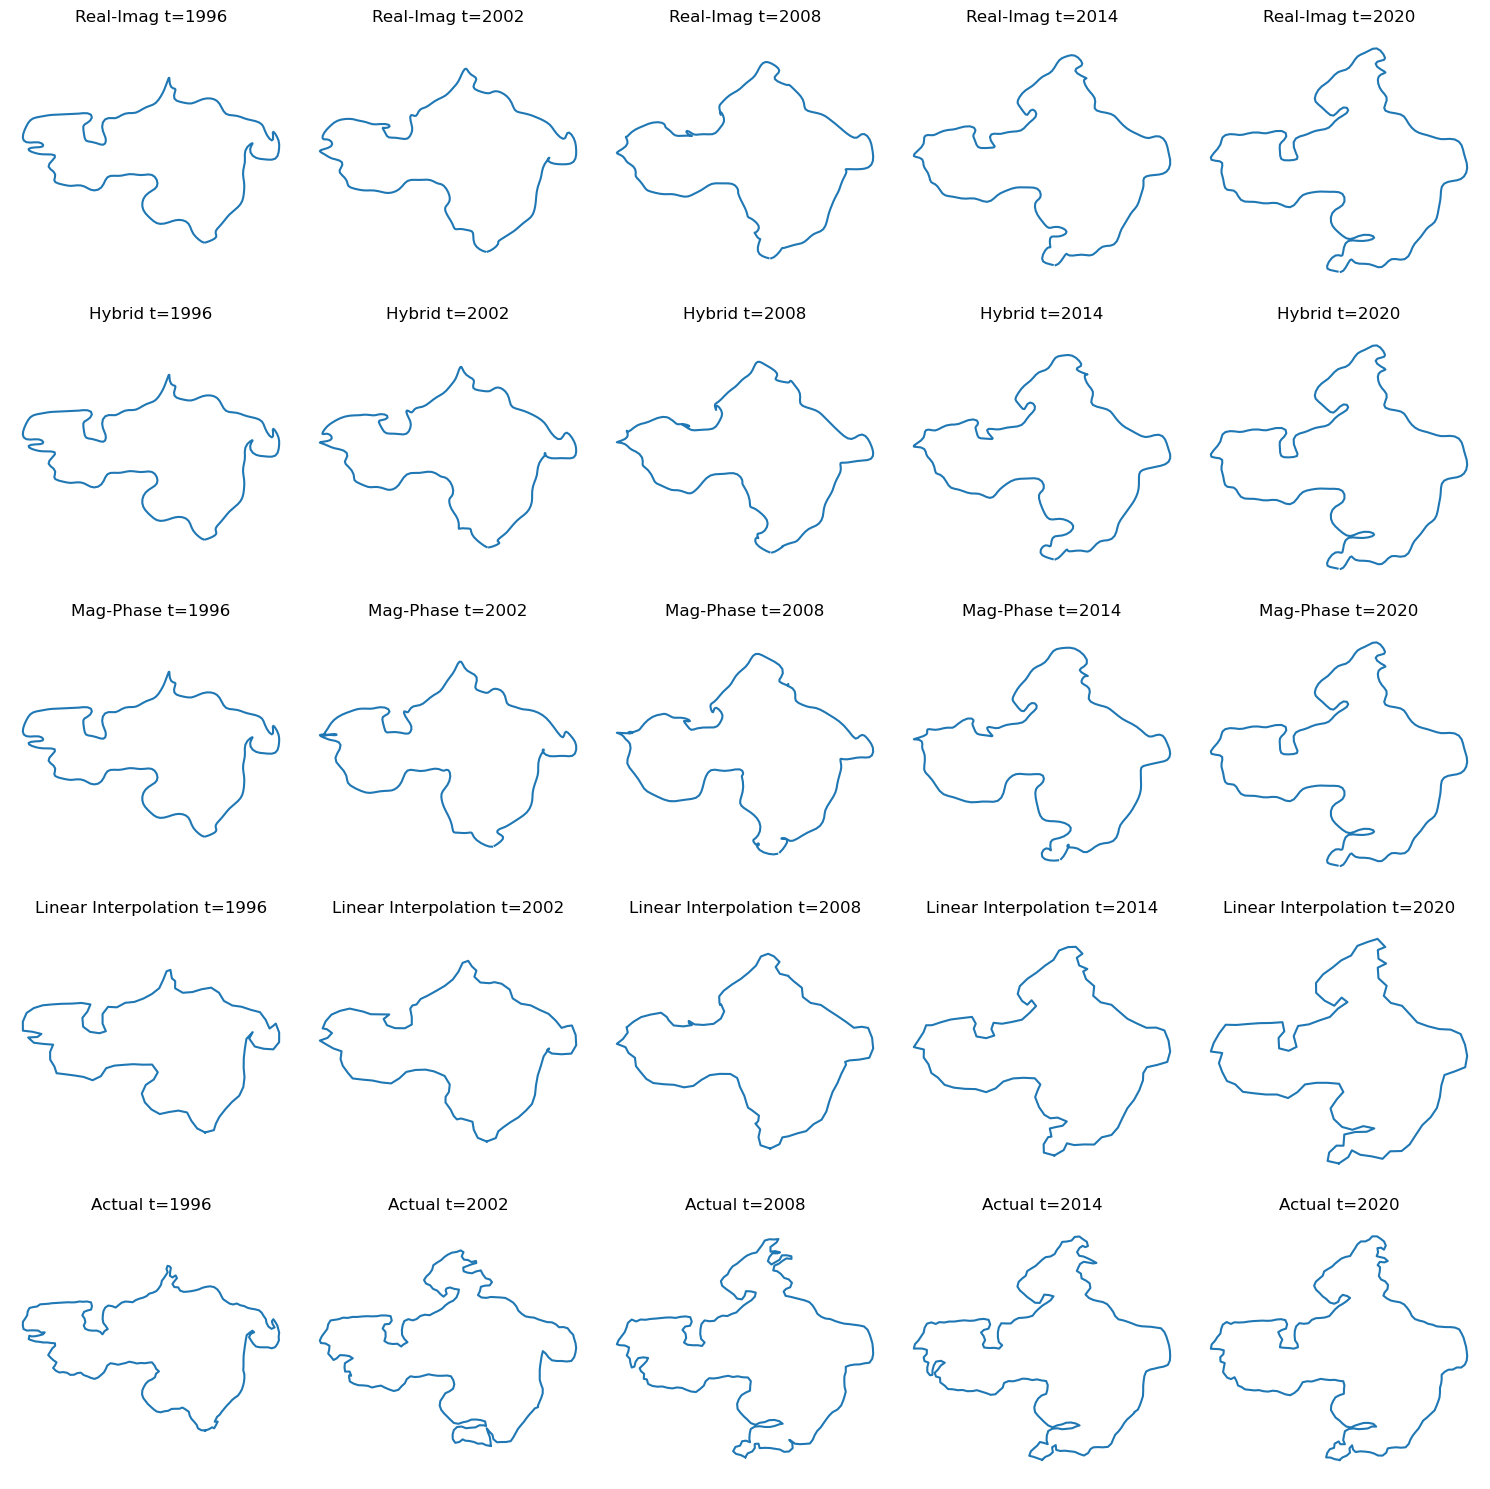

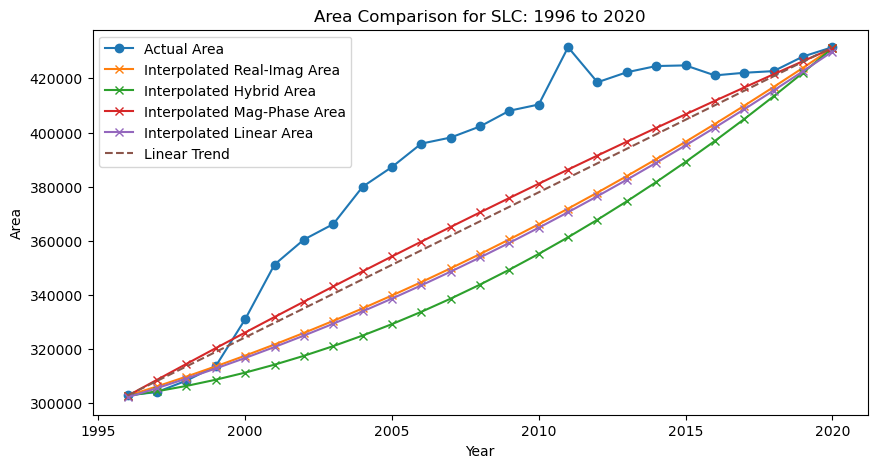

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


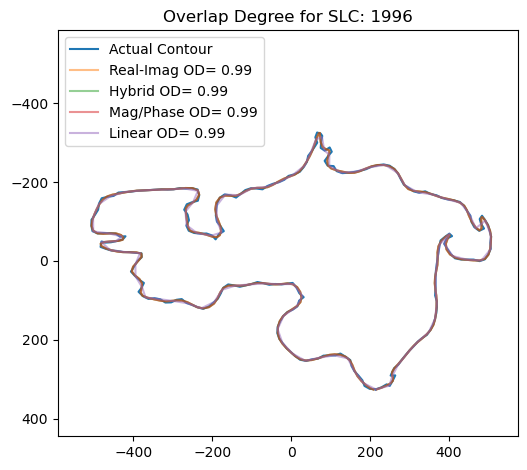

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-pac

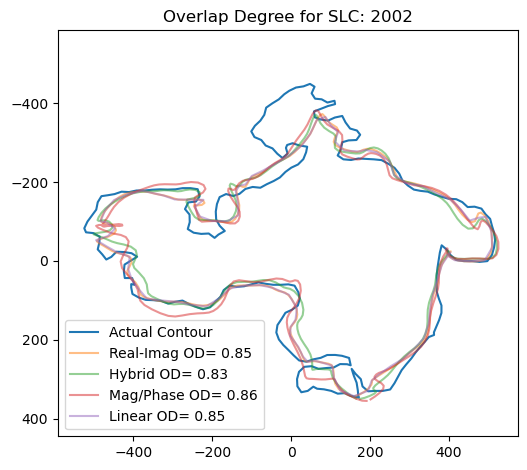

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/gl

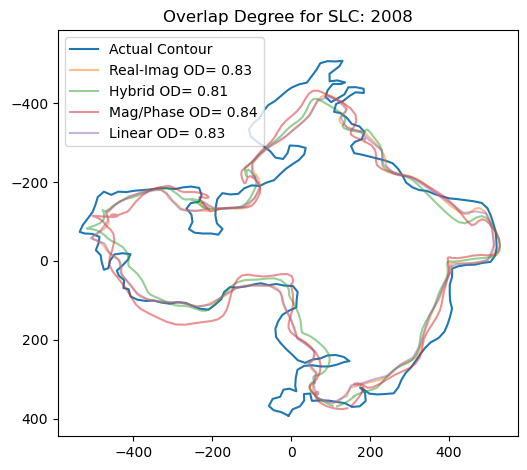

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


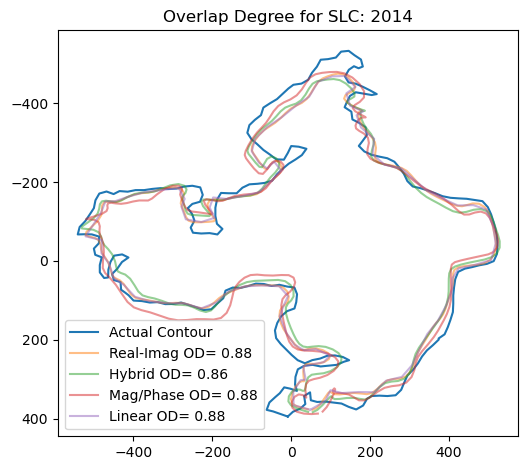

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


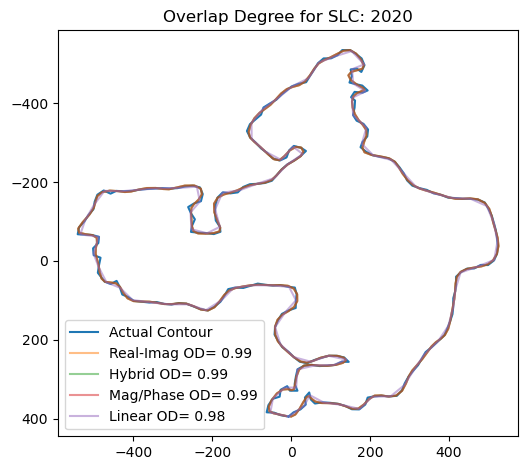

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/em

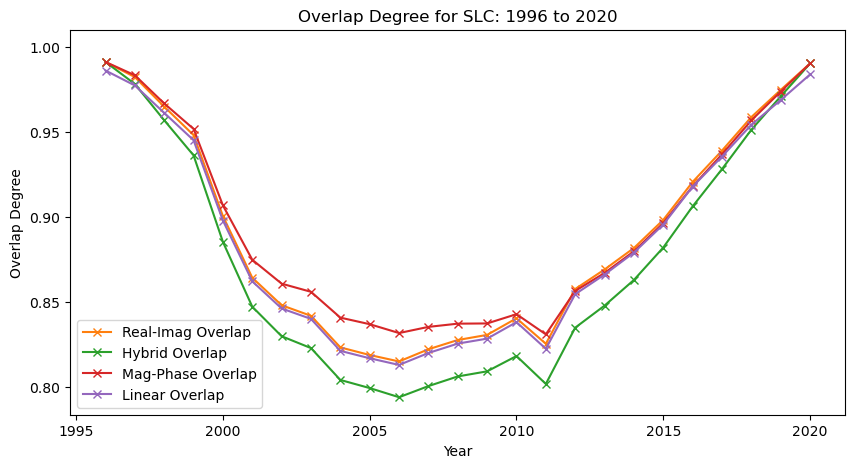

In [60]:
validate_methods("SLC", 1996, 2020, num_params=100, visualize=4)

### 3.2 Lake Mead

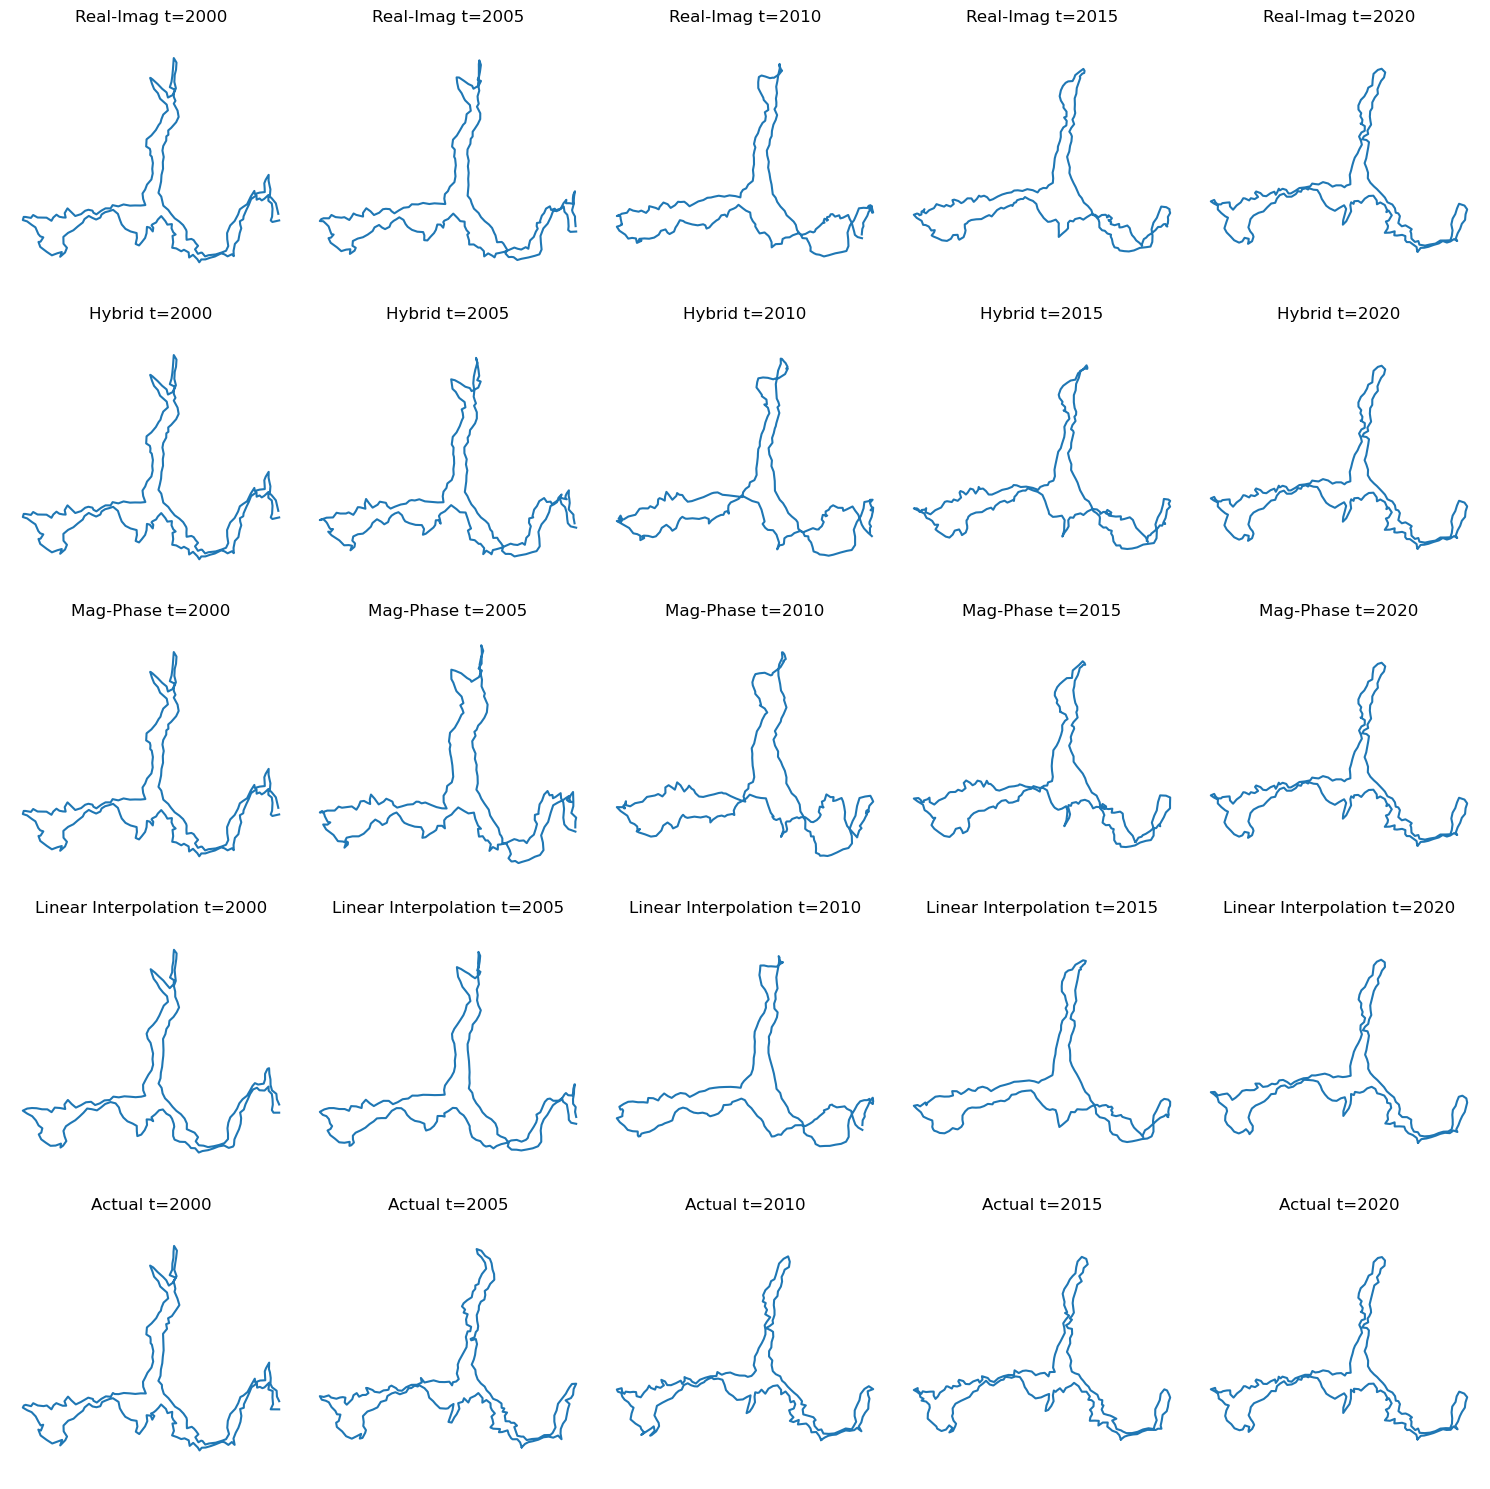

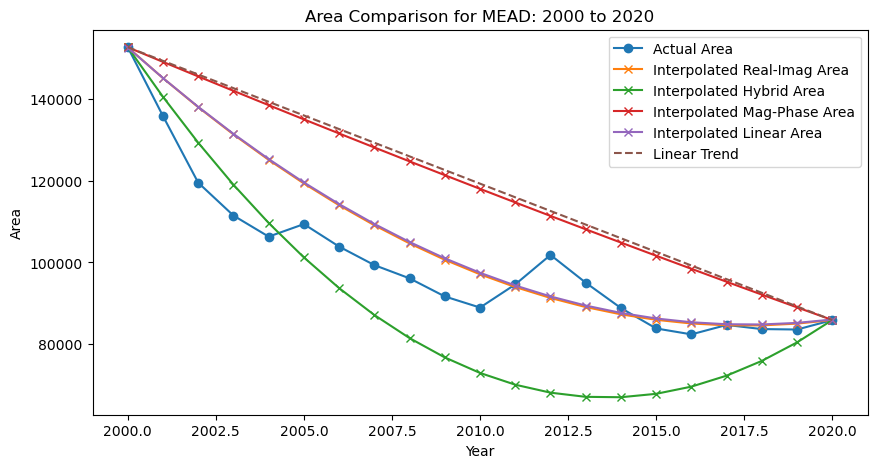

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


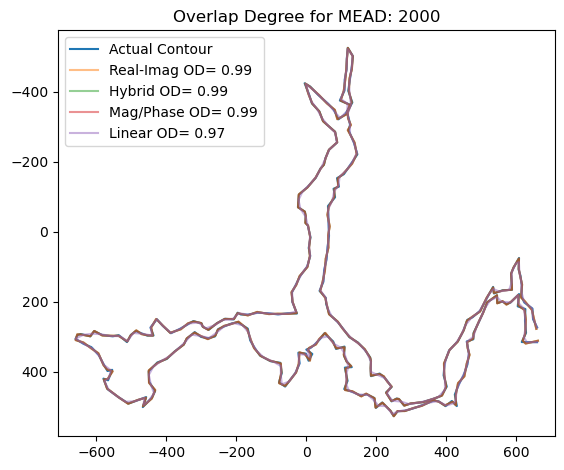

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-pac

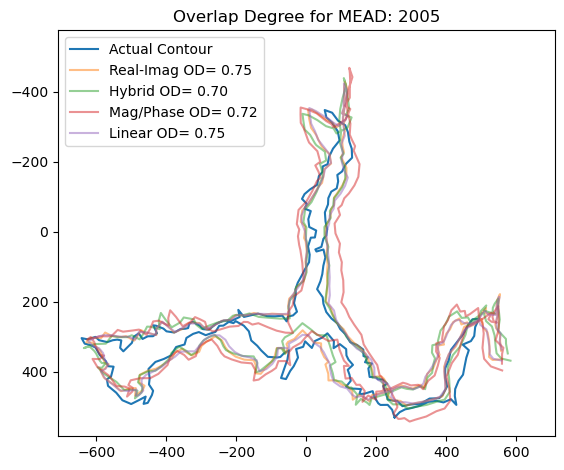

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-pac

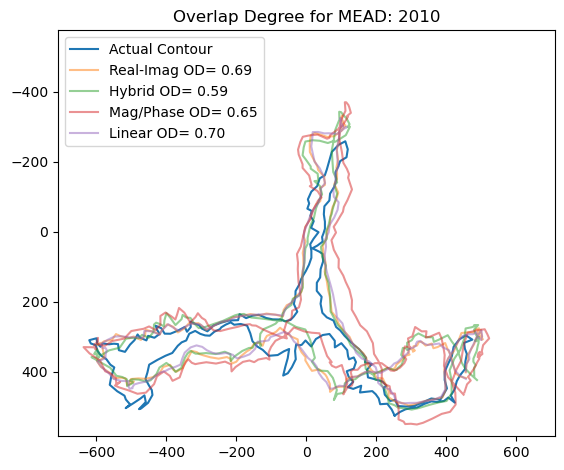

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-pac

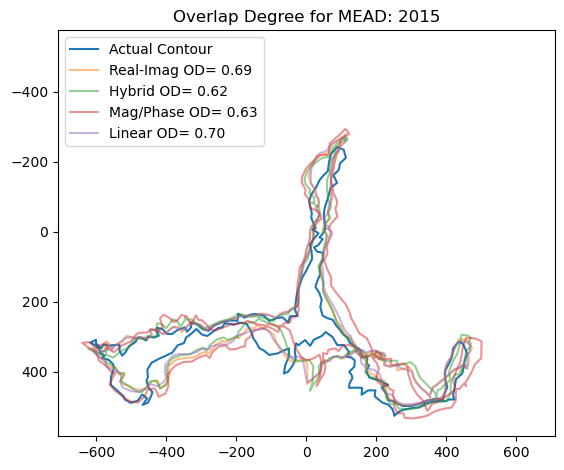

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


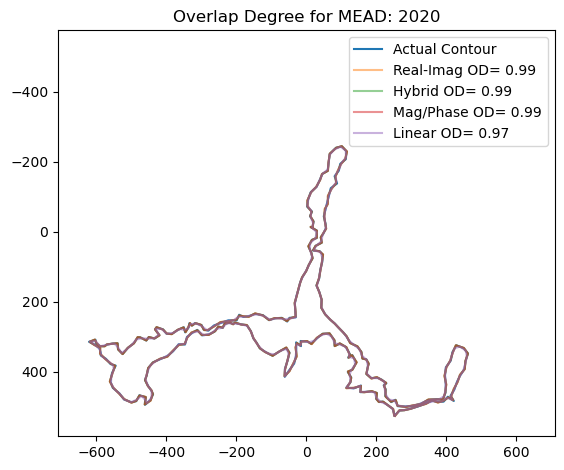

/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/emilyguan/opt/anaconda3/envs/glacier/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/emilyguan/opt/anaconda3/envs/gl

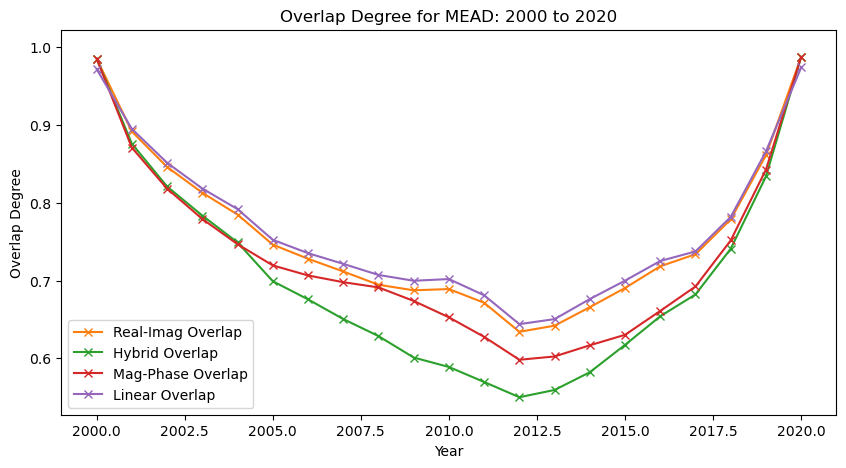

In [61]:
validate_methods("MEAD", 2000, 2020, num_params=230, visualize=4)